<a href="https://colab.research.google.com/github/123Thehara/5DATA004W_Thehara_Streamlit/blob/main/Thehara_6BUIS017C_1_20211547_w1957198.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- Task 1a: Extract and Store S&P 500 Tickers from Wikipedia ---

In [12]:
import os
import warnings
from io import StringIO
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36"}
out_dir = "outputs"                  # folder to save results
csv_path = os.path.join(out_dir, "sp500_tickers.csv")
txt_path = os.path.join(out_dir, "sp500_tickers.txt")

# suppress noisy warnings (keeps output clean)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# ensure output folder exists
os.makedirs(out_dir, exist_ok=True)

try:
    print(f"Attempting to read tables from: {url}\n")
    resp = requests.get(url, headers=headers, timeout=15)
    resp.raise_for_status()

    # parse page and find a likely S&P table
    soup = BeautifulSoup(resp.text, "html.parser")
    tables = soup.find_all("table")
    target = None
    for t in tables:
        txt = t.get_text(separator=" ").lower()
        if "symbol" in txt and "security" in txt:
            target = t
            break
    if target is None:
        # fallback to first wikitable sortable
        target = soup.find("table", {"class": "wikitable sortable"})
        if target is None:
            raise RuntimeError("Could not locate an S&P table on the page.")

    # read into DataFrame without the literal-string warning (use StringIO)
    df = pd.read_html(StringIO(str(target)))[0]

    # find the symbol/ticker column robustly
    col_candidates = [c for c in df.columns if "symbol" in str(c).lower() or "ticker" in str(c).lower()]
    if not col_candidates:
        raise KeyError("Could not find 'Symbol' or 'Ticker' column in the S&P table.")
    ticker_col = col_candidates[0]

    # extract, clean, uppercase, remove dots/spaces, drop duplicates
    symbols = df[ticker_col].astype(str).str.strip()
    symbols = symbols.str.replace(r"\.", "", regex=True)
    symbols = symbols.str.replace(r"\s+", "", regex=True).str.upper()
    symbols = symbols.drop_duplicates().reset_index(drop=True)

    # save outputs
    symbols.to_csv(csv_path, index=False, header=True)
    symbols.to_csv(txt_path, index=False, header=False)

    print(f"✅ Successfully identified the S&P 500 table. Shape: {df.shape}")
    print(f"✅ Extracted {len(symbols)} S&P 500 tickers after cleaning.\n")
    print(f"✅ Saved CSV -> {csv_path}")
    print(f"✅ Saved TXT -> {txt_path}")
    print("\n--- First 10 S&P 500 tickers ---")
    print(symbols.head(10).tolist())

except requests.exceptions.RequestException as e:
    print("✖ ERROR (Web request):", e)
except KeyError as e:
    print("✖ ERROR (Data extraction):", e)
except Exception as e:
    print("✖ Unexpected error:", e)

Attempting to read tables from: https://en.wikipedia.org/wiki/List_of_S%26P_500_companies

✅ Successfully identified the S&P 500 table. Shape: (503, 8)
✅ Extracted 503 S&P 500 tickers after cleaning.

✅ Saved CSV -> outputs/sp500_tickers.csv
✅ Saved TXT -> outputs/sp500_tickers.txt

--- First 10 S&P 500 tickers ---
['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


In [13]:
# --- Task 1b: Load S&P 500 Tickers Daily Performance using yfinance ---

In [14]:
# 1. Install yfinance
!pip install yfinance

In [22]:
import os
import yfinance as yf
import pandas as pd

# use tickers loaded in Task 1a
sp500_tickers = symbols.tolist()

start_date = "2022-01-01"
end_date = "2025-01-01"

print(f"✅ Loaded {len(sp500_tickers)} tickers.\n")
print(f"Attempting download for {len(sp500_tickers)} tickers from {start_date} to {end_date} ...\n")

try:
    # download data for the tickers
    df_stock_data = yf.download(
        sp500_tickers,
        start=start_date,
        end=end_date,
        group_by='ticker',
        progress=True,
        auto_adjust=False,
        actions=False,
        threads=True
    )

    # check which tickers failed
    downloaded = df_stock_data.columns.get_level_values(0).unique().tolist()
    missing = [t for t in sp500_tickers if t not in downloaded]

    print("\nError:yfinance:")
    print(f"{len(missing)} Failed downloads:")
    if missing:
        print(" ", missing)
    else:
        print("  None")

    if missing:
        print("⚠️  WARNING:", len(missing), "tickers could not be downloaded.")
    else:
        print("✅ All requested tickers downloaded (where data exists).")

    # save the raw data
    out_dir = "outputs"
    os.makedirs(out_dir, exist_ok=True)
    raw_path = os.path.join(out_dir, "task1b_sp500_raw.csv")
    df_stock_data.to_csv(raw_path)
    print(f"✅ Saved raw data -> {raw_path}\n")

    # preview
    print("--- Preview (first 5 rows) ---\n")
    display(df_stock_data.head(5))

    print("\n✅ Task 1b complete.")

except Exception as e:
    print("✖ ERROR:", e)

✅ Loaded 503 tickers.

Attempting download for 503 tickers from 2022-01-01 to 2025-01-01 ...



[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
4 Failed downloads:
ERROR:yfinance:['BRKB', 'BFB']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:['SOLS', 'Q']: YFPricesMissingError('possibly delisted; no price data found  (1d 2022-01-01 -> 2025-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1641013200, endDate = 1735707600")')



Error:yfinance:
0 Failed downloads:
  None
✅ All requested tickers downloaded (where data exists).
✅ Saved raw data -> outputs/task1b_sp500_raw.csv

--- Preview (first 5 rows) ---



Ticker     BRKB                                        AEP             \
Price      Open High Low Close Adj Close Volume       Open       High   
Date                                                                    
2022-01-03  NaN  NaN NaN   NaN       NaN    NaN  88.629997  88.769997   
2022-01-04  NaN  NaN NaN   NaN       NaN    NaN  88.500000  89.940002   
2022-01-05  NaN  NaN NaN   NaN       NaN    NaN  88.660004  90.290001   
2022-01-06  NaN  NaN NaN   NaN       NaN    NaN  89.500000  90.309998   
2022-01-07  NaN  NaN NaN   NaN       NaN    NaN  88.989998  91.269997   

Ticker                            ...        WDC                        \
Price             Low      Close  ...        Low      Close  Adj Close   
Date                              ...                                    
2022-01-03  87.529999  88.610001  ...  49.160999  49.833710  49.683193   
2022-01-04  88.500000  88.650002  ...  49.826153  51.111111  50.956738   
2022-01-05  88.660004  89.470001  ...  50.687832  50.687832  50.534733   
2022-01-06  88.910004  89.180000  ...  48.767952  48.934238  48.786438   
2022-01-07  88.559998  90.800003  ...  48.767952  49.758125  49.607834   

Ticker                     USB                                              \
Price        Volume       Open       High        Low      Close  Adj Close   
Date                                                                         
2022-01-03  3899013  56.080002  57.400002  56.080002  57.270000  48.126858   
2022-01-04  4965219  58.110001  59.080002  57.910000  58.770000  49.387386   
2022-01-05  7826736  59.189999  59.290001  58.400002  58.459999  49.126881   
2022-01-06  9940096  59.529999  60.070000  58.939999  60.049999  50.463032   
2022-01-07  5082172  59.900002  61.169998  59.680000  61.000000  51.261368   

Ticker               
Price        Volume  
Date                 
2022-01-03  5430900  
2022-01-04  7552600  
2022-01-05  6527200  
2022-01-06  5783200  
2022-01-07  7040100  

[5 rows x 3018 columns]


✅ Task 1b complete.


In [23]:
# --- Task 1c: Identify and Remove Invalid Data ---

In [25]:
# --- Task 1c: Identify and Remove Invalid Data ---

print("\n--- Starting Data Cleaning (Invalid Data) ---\n")

# 1. Check overall missing values
initial_missing = (df_stock_data.isnull().sum().sum() / df_stock_data.size) * 100
print(f"Initial missing percentage: {initial_missing:.2f}%")

# 2. Drop rows where *all* tickers are NaN for a given day
initial_rows = df_stock_data.shape[0]
df_clean = df_stock_data.dropna(how='all')
rows_after = df_clean.shape[0]

print(f"Rows before cleaning: {initial_rows}")
print(f"Rows after dropping all-NaN rows: {rows_after}")

# 3. Handle remaining NaNs by forward-fill then backward-fill
df_clean = df_clean.ffill().bfill()

# 4. Check remaining missing values
final_missing = (df_clean.isnull().sum().sum() / df_clean.size) * 100
print(f"Final missing percentage: {final_missing:.4f}%")

# 5. Show small preview
print("\n--- Cleaned Data Preview (first 5 rows) ---")
display(df_clean.head())

print("\n✅ Task 1c complete.")


--- Starting Data Cleaning (Invalid Data) ---

Initial missing percentage: 1.36%
Rows before cleaning: 753
Rows after dropping all-NaN rows: 753
Final missing percentage: 0.7952%

--- Cleaned Data Preview (first 5 rows) ---


Ticker     BRKB                                        AEP             \
Price      Open High Low Close Adj Close Volume       Open       High   
Date                                                                    
2022-01-03  NaN  NaN NaN   NaN       NaN    NaN  88.629997  88.769997   
2022-01-04  NaN  NaN NaN   NaN       NaN    NaN  88.500000  89.940002   
2022-01-05  NaN  NaN NaN   NaN       NaN    NaN  88.660004  90.290001   
2022-01-06  NaN  NaN NaN   NaN       NaN    NaN  89.500000  90.309998   
2022-01-07  NaN  NaN NaN   NaN       NaN    NaN  88.989998  91.269997   

Ticker                            ...        WDC                        \
Price             Low      Close  ...        Low      Close  Adj Close   
Date                              ...                                    
2022-01-03  87.529999  88.610001  ...  49.160999  49.833710  49.683193   
2022-01-04  88.500000  88.650002  ...  49.826153  51.111111  50.956738   
2022-01-05  88.660004  89.470001  ...  50.687832  50.687832  50.534733   
2022-01-06  88.910004  89.180000  ...  48.767952  48.934238  48.786438   
2022-01-07  88.559998  90.800003  ...  48.767952  49.758125  49.607834   

Ticker                     USB                                              \
Price        Volume       Open       High        Low      Close  Adj Close   
Date                                                                         
2022-01-03  3899013  56.080002  57.400002  56.080002  57.270000  48.126858   
2022-01-04  4965219  58.110001  59.080002  57.910000  58.770000  49.387386   
2022-01-05  7826736  59.189999  59.290001  58.400002  58.459999  49.126881   
2022-01-06  9940096  59.529999  60.070000  58.939999  60.049999  50.463032   
2022-01-07  5082172  59.900002  61.169998  59.680000  61.000000  51.261368   

Ticker               
Price        Volume  
Date                 
2022-01-03  5430900  
2022-01-04  7552600  
2022-01-05  6527200  
2022-01-06  5783200  
2022-01-07  7040100  

[5 rows x 3018 columns]


✅ Task 1c complete.


In [26]:
# --- Task 2a: Calculate Daily Returns  ---

In [45]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# load cleaned stock dataset from Task 1b
df_stock = pd.read_csv("outputs/task1b_sp500_raw.csv", header=[0,1], index_col=0, parse_dates=True)

print("Loaded stock data with MultiIndex columns.\n")

# select all 'Close' price columns
close_cols = [c for c in df_stock.columns if str(c[1]).lower() == "close"]
close_prices = df_stock[close_cols].copy()

# rename columns to just ticker names
close_prices.columns = [c[0] for c in close_prices.columns]

# calculate daily returns
daily_returns = close_prices.pct_change().dropna(how="all")

print("🟩 Daily returns calculated successfully.\n")

# preview (first 5 rows)
print("--- Daily Returns Preview (first 5 rows) ---\n")
print(daily_returns.head())

# create summary statistics table
summary = daily_returns.describe().round(6)

print("\n--- Daily Returns Summary Statistics ---\n")
print(summary)

# save outputs
daily_returns.to_csv("outputs/task2a_daily_returns.csv")
summary.to_csv("outputs/task2a_daily_returns_summary.csv")

print("\n🟩 Saved daily returns -> outputs/task2a_daily_returns.csv")
print("🟩 Saved summary stats -> outputs/task2a_daily_returns_summary.csv")
print("\n🟩 Task 2a complete.")

Loaded stock data with MultiIndex columns.

🟩 Daily returns calculated successfully.

--- Daily Returns Preview (first 5 rows) ---

            BRKB       AEP       IPG       UNH       ELV      ADSK         V       COR       STZ       KEY  ...  \
Date                                                                                                        ...   
2022-01-04   NaN  0.000451  0.019920 -0.022657 -0.014391 -0.019491  0.004652 -0.009501  0.007041  0.052587  ...   
2022-01-05   NaN  0.009250 -0.030208 -0.002465  0.000109 -0.049858 -0.011058  0.008678 -0.004870 -0.006043  ...   
2022-01-06   NaN -0.003241  0.015038 -0.040924 -0.040963 -0.000795 -0.001136 -0.015472 -0.033825  0.051074  ...   
2022-01-07   NaN  0.018166 -0.006878 -0.023528 -0.010149 -0.006777 -0.012696  0.020468  0.005678  0.016197  ...   
2022-01-10   NaN -0.003304 -0.005594  0.013956  0.006529  0.000267 -0.023000  0.011418  0.003656 -0.000759  ...   

                KEYS       AJG       EOG        EW       ALL  

In [51]:
# --- Task 2b: Beta Calculation ---

In [52]:
import os
from IPython.display import display

# load daily returns (from memory or saved file)
try:
    daily = daily_returns_final.copy()
except NameError:
    try:
        daily = daily_returns.copy()
    except NameError:
        csv_path = "outputs/task2a_daily_returns.csv"
        daily = pd.read_csv(csv_path, index_col=0, parse_dates=True)

# handle MultiIndex columns if present
if isinstance(daily.columns, pd.MultiIndex):
    cols = [c for c in daily.columns if 'daily return' in str(' '.join(map(str, c))).lower()]
    if cols:
        dr = daily.loc[:, cols].copy()
        dr.columns = [c[0] if isinstance(c, (list, tuple)) else c for c in dr.columns]
        daily = dr
    else:
        sel = []
        for c in daily.columns:
            if isinstance(c, tuple) and len(c) > 1 and 'return' in str(c[1]).lower():
                sel.append(c)
        if sel:
            daily = daily.loc[:, sel]
            daily.columns = [c[0] for c in daily.columns]
        else:
            daily.columns = [str(c) for c in daily.columns]

# clean data
daily = daily.dropna(how='all', axis=1).apply(pd.to_numeric, errors='coerce')

# calculate market return (average return across all stocks)
market_series = daily.mean(axis=1)
market_df = pd.DataFrame({'Market': market_series})

# covariance matrix
combined = pd.concat([market_df, daily], axis=1)
cov = combined.cov(min_periods=50)
market_var = cov.loc['Market', 'Market']

# beta calculation
stock_cov_with_market = cov.loc['Market', daily.columns]
beta_series = stock_cov_with_market / market_var
metrics_df = pd.DataFrame({'Beta': beta_series}).sort_values('Beta', ascending=False)

# final cleanup
metrics_df['Beta'] = metrics_df['Beta'].replace([np.inf, -np.inf], np.nan).fillna(0)
beta_metrics = metrics_df[metrics_df['Beta'] != 0].copy()

# save
os.makedirs("outputs", exist_ok=True)
out_csv = "outputs/task2b_beta_metrics.csv"
beta_metrics.to_csv(out_csv)

# output
print("✅ SUCCESS: Task 2b (Beta) calculated!")
print(f"✅ Saved Beta metrics -> {out_csv}\n")
print("--- Task 2b: Top Beta values ---")
display(beta_metrics.head(12))

print(f"\nNumber of stocks with non-zero Beta: {len(beta_metrics)}")

✅ SUCCESS: Task 2b (Beta) calculated!
✅ Saved Beta metrics -> outputs/task2b_beta_metrics.csv

--- Task 2b: Top Beta values ---


,Beta
COIN,2.985872
XYZ,2.615908
TTD,2.197462
APP,2.135442
PLTR,2.124470
CCL,2.098825
NCLH,2.062814
HOOD,2.034993
GNRC,2.003202
MPWR,1.994474



Number of stocks with non-zero Beta: 499


In [54]:
# --- Task 2c: Annual Volatility Calculation ---

In [56]:
import os
import pandas as pd
import numpy as np
from IPython.display import display

# load daily returns from memory or file
try:
    daily = daily_returns_final.copy()
except NameError:
    try:
        daily = daily_returns.copy()
    except NameError:
        csv_path = "outputs/task2a_daily_returns.csv"
        daily = pd.read_csv(csv_path, index_col=0, parse_dates=True)

# clean dataset
daily = daily.dropna(how="all", axis=1).apply(pd.to_numeric, errors='coerce')

# calculate **annual** volatility
vol_series = daily.std() * np.sqrt(252)
vol_df = pd.DataFrame({'Annual Volatility': vol_series}).sort_values('Annual Volatility', ascending=False)

# save output
os.makedirs("outputs", exist_ok=True)
vol_path = "outputs/task2c_annual_volatility_metrics.csv"
vol_df.to_csv(vol_path)

print("🟩 SUCCESS: Task 2c (Annual Volatility) calculated!")
print(f"🟩 Saved volatility metrics -> {vol_path}\n")

print("--- Task 2c: Highest Annual Volatility Stocks ---\n")
display(vol_df.head(12))

print(f"\nNumber of stocks with calculated volatility: {len(vol_df)}")

🟩 SUCCESS: Task 2c (Annual Volatility) calculated!
🟩 Saved volatility metrics -> outputs/task2c_annual_volatility_metrics.csv

--- Task 2c: Highest Annual Volatility Stocks ---



,Annual Volatility
COIN,0.953848
SMCI,0.901957
APP,0.788374
PLTR,0.690932
XYZ,0.653825
HOOD,0.651759
TTD,0.647665
TSLA,0.613038
MRNA,0.603608
EPAM,0.602363



Number of stocks with calculated volatility: 499


In [57]:
# --- Task 3: Agglomerative clustering (Beta) ---

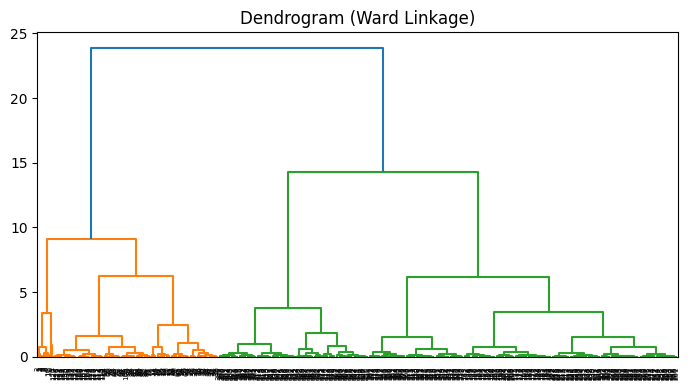

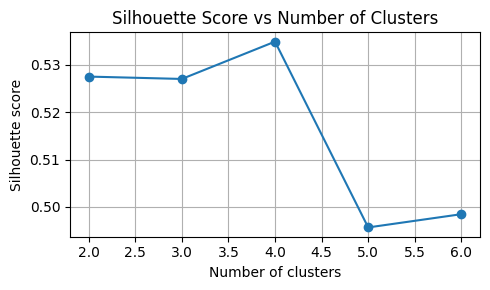


Best number of clusters from silhouette: 4

--- Cluster Profile ---



,count,mean,std,min,max
Cluster,,,,,
0,129,1.4092,0.1773,1.1921,1.8717
1,241,0.9543,0.1369,0.6803,1.1786
2,117,0.5018,0.1183,0.1915,0.6661
3,12,2.1812,0.3088,1.9490,2.9859


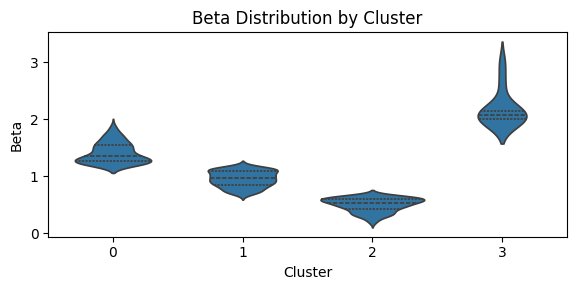

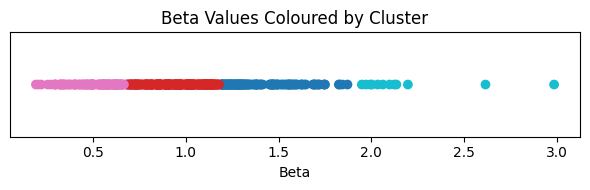


✅ SUCCESS: Task 3c completed!
✅ Saved cluster results → outputs/task3c_clusters.csv

--- Clustered Beta Table (first 10) ---



,Beta,Cluster
COIN,2.985872,3
XYZ,2.615908,3
TTD,2.197462,3
APP,2.135442,3
PLTR,2.124470,3
CCL,2.098825,3
NCLH,2.062814,3
HOOD,2.034993,3
GNRC,2.003202,3
MPWR,1.994474,3



Number of stocks assigned to clusters: 499


In [69]:
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# load Beta metrics
beta_df = beta_metrics.copy()
beta_df = beta_df[beta_df['Beta'] > 0].copy()
beta_series = beta_df['Beta'].astype(float)
X = beta_series.to_frame()

# scale Beta values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# dendrogram
plt.figure(figsize=(7,4))
linkage_matrix = linkage(X_scaled, method='ward')
dendrogram(linkage_matrix)
plt.title("Dendrogram (Ward Linkage)")
plt.tight_layout()
plt.show()

# silhouette scan for k = 2..6
ks = range(2,7)
scores = []
for k in ks:
    model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = model.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores.append(score)

plt.figure(figsize=(5,3))
plt.plot(list(ks), scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.tight_layout()
plt.show()

best_k = list(ks)[np.argmax(scores)]
print(f"\nBest number of clusters from silhouette: {best_k}")

# final clustering
final_model = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
labels_final = final_model.fit_predict(X_scaled)
beta_df['Cluster'] = labels_final

# cluster summary
cluster_profile = beta_df.groupby('Cluster')['Beta'].agg(['count','mean','std','min','max']).round(4)
print("\n--- Cluster Profile ---\n")
display(cluster_profile)

# violin plot
plt.figure(figsize=(6,3))
sns.violinplot(data=beta_df, x='Cluster', y='Beta', inner='quartile')
plt.title("Beta Distribution by Cluster")
plt.tight_layout()
plt.show()

# scatter of beta by cluster
plt.figure(figsize=(6,2))
plt.scatter(beta_df['Beta'], np.zeros_like(beta_df['Beta']), c=beta_df['Cluster'], cmap='tab10')
plt.yticks([])
plt.xlabel("Beta")
plt.title("Beta Values Coloured by Cluster")
plt.tight_layout()
plt.show()

# save results
os.makedirs("outputs", exist_ok=True)
out_path = "outputs/task3c_clusters.csv"
beta_df.to_csv(out_path, index=True)

print("\n✅ SUCCESS: Task 3c completed!")
print(f"✅ Saved cluster results → {out_path}")
print(f"\n--- Clustered Beta Table (first 10) ---\n")
display(beta_df.head(10))
print(f"\nNumber of stocks assigned to clusters: {len(beta_df)}")

In [71]:
# --- Task 4c: K-Means clustering for Beta and Annual Volatility ---

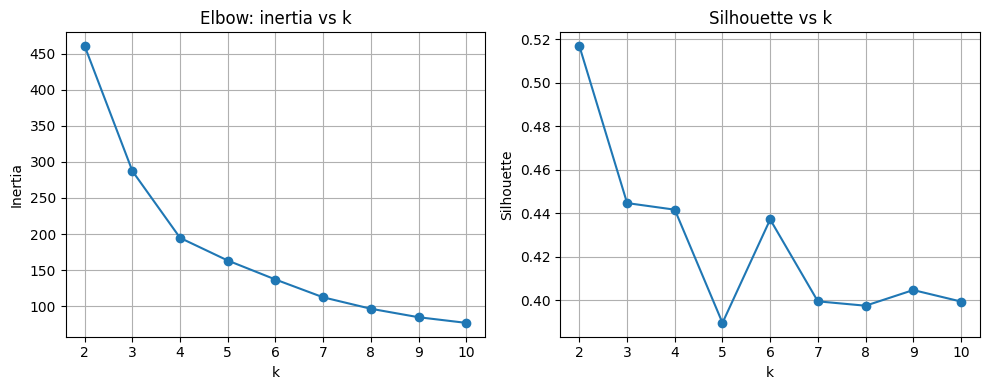


✅ Chosen k = 2 (based on silhouette/elbow)

--- Cluster Summary ---



Beta                                 Annual_Volatility                                
        count    mean     std     min     max             count    mean     std     min     max
Cluster                                                                                        
0         140  1.4529  0.3175  0.6183  2.9859               140  0.4353  0.1059  0.3169  0.9538
1         359  0.8169  0.2606  0.1915  1.2895               359  0.2632  0.0461  0.1561  0.4167

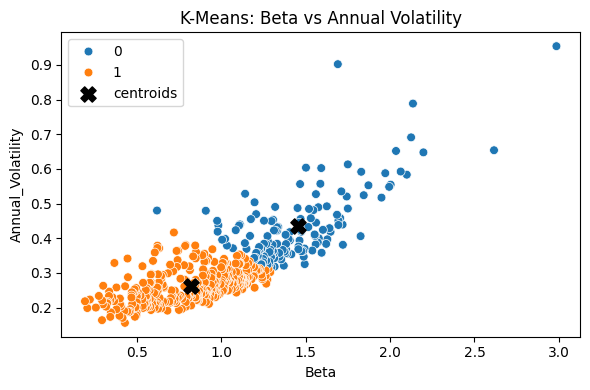

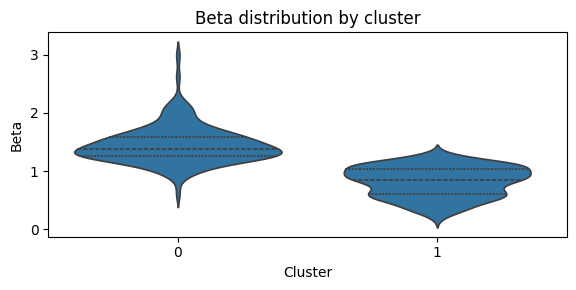

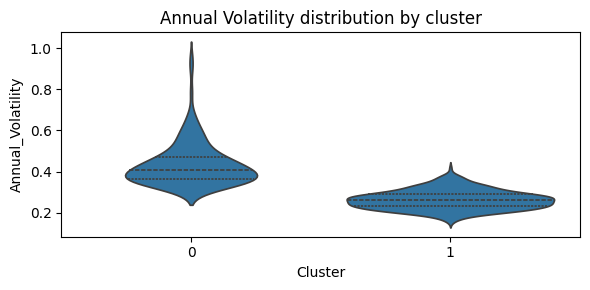


✅ SUCCESS: Task 4c completed!
✅ Saved K-Means cluster results → outputs/task4c_kmeans_beta_vol_clusters.csv

--- Clustered Table (first 10) ---



,Beta,Annual_Volatility,Cluster
COIN,2.985872,0.953848,0
XYZ,2.615908,0.653825,0
TTD,2.197462,0.647665,0
APP,2.135442,0.788374,0
PLTR,2.124470,0.690932,0
CCL,2.098825,0.583374,0
NCLH,2.062814,0.592448,0
HOOD,2.034993,0.651759,0
GNRC,2.003202,0.554590,0
MPWR,1.994474,0.548291,0



Number of stocks assigned to clusters: 499


In [75]:
import os
from sklearn.cluster import KMeans
from IPython.display import display

# prepare data (find Beta and Annual Volatility in memory)
cands = ['beta_metrics','beta_df','metrics_df','metrics','results','annual_vol_df','vol_df']
beta_src = None
vol_src = None

for name in cands:
    if name in globals():
        obj = globals()[name]
        if isinstance(obj, pd.DataFrame):
            cols = [c.lower() for c in obj.columns]
            if 'beta' in cols and beta_src is None:
                beta_src = obj
            if 'annual_volatility' in cols or 'annual volatility' in cols or 'annual_vol' in cols:
                vol_src = obj

# fallback: metrics_df may contain both
if beta_src is None and 'metrics_df' in globals() and isinstance(globals()['metrics_df'], pd.DataFrame):
    if 'Beta' in globals()['metrics_df'].columns:
        beta_src = globals()['metrics_df']

if vol_src is None and 'metrics_df' in globals() and isinstance(globals()['metrics_df'], pd.DataFrame):
    # try multiple possible column names
    df_tmp = globals()['metrics_df']
    for cand in ['Annual_Volatility','Annual Volatility','annual_volatility','annual volatility','annual_vol']:
        if cand in df_tmp.columns:
            vol_src = df_tmp
            break

if beta_src is None:
    raise RuntimeError("Beta data not found. Ensure a DataFrame with a 'Beta' column is available (e.g. beta_metrics or metrics_df).")
if vol_src is None:
    raise RuntimeError("Annual volatility data not found. Ensure a DataFrame with an 'Annual_Volatility' column is available (e.g. annual_vol_df or metrics_df).")

# assemble unified dataframe
beta_df = beta_src.copy()
if 'Ticker' in beta_df.columns:
    beta_df = beta_df.set_index('Ticker')

# get volatility series (try index alignment by ticker or column extraction)
if vol_src is beta_src:
    vol_series = beta_df[[c for c in beta_df.columns if 'vol' in c.lower() or 'annual' in c.lower()]].iloc[:,0]
else:
    vol_tmp = vol_src.copy()
    if 'Ticker' in vol_tmp.columns:
        vol_tmp = vol_tmp.set_index('Ticker')
    # find best volatility column name
    vol_col = None
    for c in vol_tmp.columns:
        if 'annual' in str(c).lower() or 'volatility' in str(c).lower() or 'vol' in str(c).lower():
            vol_col = c
            break
    if vol_col is None:
        raise RuntimeError("Could not identify a volatility column in the provided volatility DataFrame.")
    vol_series = vol_tmp[vol_col]

# combine (align by index)
combined = pd.DataFrame({
    'Beta': beta_df['Beta'].astype(float),
}).join(vol_series.rename('Annual_Volatility'), how='inner')

combined = combined.dropna()
if combined.empty:
    raise RuntimeError("Combined Beta and Annual_Volatility produced an empty dataset after alignment and dropna.")

# features and scaling
X = combined[['Beta','Annual_Volatility']].astype(float)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# scan K values
Ks = list(range(2,11))
inertias = []
sil_scores = []

for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labs = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    try:
        sil = silhouette_score(X_scaled, labs)
    except Exception:
        sil = np.nan
    sil_scores.append(sil)

# plotting: elbow + silhouette with spacing
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(Ks, inertias, marker='o')
plt.title("Elbow: inertia vs k")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(Ks, sil_scores, marker='o')
plt.title("Silhouette vs k")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.grid(True)

plt.tight_layout()
plt.show()

# choose best k (prefer silhouette max; fallback to elbow heuristic)
if not all(np.isnan(sil_scores)):
    best_k = Ks[int(np.nanargmax(sil_scores))]
else:
    # fallback: choose elbow where relative drop stabilizes
    drops = np.diff(inertias)
    rel = drops / (inertias[:-1] + 1e-9)
    best_k = Ks[int(np.argmin(rel)) + 1]  # +1 because diff length = k-1

print(f"\n✅ Chosen k = {best_k} (based on silhouette/elbow)")

# final fit
final_km = KMeans(n_clusters=best_k, n_init=20, random_state=42)
labels = final_km.fit_predict(X_scaled)
combined['Cluster'] = labels

# cluster profile
profile = combined.groupby('Cluster')[['Beta','Annual_Volatility']].agg(['count','mean','std','min','max']).round(4)
print("\n--- Cluster Summary ---\n")
display(profile)

# scatter & cluster centres
plt.figure(figsize=(6,4))
sns.scatterplot(x='Beta', y='Annual_Volatility', hue='Cluster', palette='tab10', data=combined, s=40)
centers = scaler.inverse_transform(final_km.cluster_centers_)
plt.scatter(centers[:,0], centers[:,1], marker='X', s=120, c='black', label='centroids')
plt.title("K-Means: Beta vs Annual Volatility")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# violin for Beta per cluster (space between visuals)
plt.figure(figsize=(6,3))
sns.violinplot(x='Cluster', y='Beta', data=combined.reset_index(), inner='quartile')
plt.title("Beta distribution by cluster")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
sns.violinplot(x='Cluster', y='Annual_Volatility', data=combined.reset_index(), inner='quartile')
plt.title("Annual Volatility distribution by cluster")
plt.tight_layout()
plt.show()

# save results
os.makedirs("outputs", exist_ok=True)
out_path = "outputs/task4c_kmeans_beta_vol_clusters.csv"
combined.to_csv(out_path, index=True)

print("\n✅ SUCCESS: Task 4c completed!")
print(f"✅ Saved K-Means cluster results → {out_path}")
print("\n--- Clustered Table (first 10) ---\n")
display(combined.head(10))
print(f"\nNumber of stocks assigned to clusters: {len(combined)}")

In [79]:
# --- Task 5b: Implementation ---

✅ Loaded daily returns. Shape:
 (752, 499)
✅ Loaded clusters -> outputs/task4c_kmeans_beta_vol_clusters.csv
✅ Using cluster column: 'Cluster'. Unique clusters:
 2
✅ Selected tickers for portfolio: ['GEV', 'EME']

Portfolio annual return (est): 0.403
Portfolio annual vol (est):    0.216
Portfolio Sharpe (est):        1.866

✅ Saved: outputs/task5b_holdings.csv and outputs/task5b_cumrets.csv



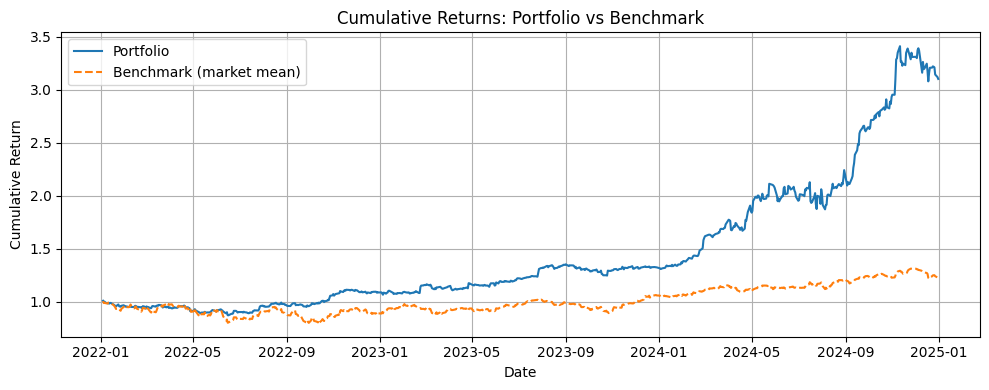


✅ Saved cumulative returns plot -> outputs/task5b_cumret_plot.png


In [86]:
import os
import matplotlib.pyplot as plt

# --- Paths (adjust if your files use different names) ---
out_dir = "outputs"
clusters_kmeans_path = os.path.join(out_dir, "task4c_kmeans_beta_vol_clusters.csv")
clusters_beta_path   = os.path.join(out_dir, "task3_beta_clusters.csv")    # optional
clusters_vol_path    = os.path.join(out_dir, "task4_vol_clusters.csv")     # optional
daily_returns_path   = os.path.join(out_dir, "task2a_daily_returns.csv")

os.makedirs(out_dir, exist_ok=True)

# --- Load daily returns (try memory first, else CSV) ---
try:
    daily_returns = daily_returns_final.copy()   # variable name used in notebook
except Exception:
    try:
        daily_returns = daily_returns.copy()
    except Exception:
        if not os.path.exists(daily_returns_path):
            raise FileNotFoundError(f"Daily returns not found in memory or file: {daily_returns_path}")
        daily_returns = pd.read_csv(daily_returns_path, index_col=0, parse_dates=True)

# Ensure dataframe has simple ticker columns (if MultiIndex, try to flatten)
if isinstance(daily_returns.columns, pd.MultiIndex):
    # attempt to select "Daily Return" level if present
    cols = [c for c in daily_returns.columns if 'daily return' in ' '.join(map(str,c)).lower()]
    if cols:
        dr = daily_returns.loc[:, cols].copy()
        dr.columns = [c[0] if isinstance(c, (list,tuple)) else c for c in dr.columns]
        daily_returns = dr
    else:
        # flatten multiindex to "TICKER" where possible
        daily_returns.columns = [c[0] if isinstance(c, tuple) else c for c in daily_returns.columns]

# drop all-empty columns and ensure numeric dtype
daily_returns = daily_returns.dropna(how='all', axis=1).apply(pd.to_numeric, errors='coerce')

print("✅ Loaded daily returns. Shape:\n", daily_returns.shape)

# --- Load clusters (prefer kmeans beta-vol clusters if available) ---
clusters = None
if os.path.exists(clusters_kmeans_path):
    clusters = pd.read_csv(clusters_kmeans_path, index_col=0)
    print(f"✅ Loaded clusters -> {clusters_kmeans_path}")
else:
    # fallback: try separate beta / vol cluster files and join by ticker
    parts = []
    if os.path.exists(clusters_beta_path):
        b = pd.read_csv(clusters_beta_path)
        if 'Ticker' in b.columns:
            b = b.set_index('Ticker')
        parts.append(b[['Cluster']].rename(columns={'Cluster':'Beta_Cluster'}))
    if os.path.exists(clusters_vol_path):
        v = pd.read_csv(clusters_vol_path)
        if 'Ticker' in v.columns:
            v = v.set_index('Ticker')
        parts.append(v[['Cluster']].rename(columns={'Cluster':'Vol_Cluster'}))
    if parts:
        clusters = pd.concat(parts, axis=1)
        print("✅ Loaded & merged Beta/Vol cluster files (fallback).\n")
    else:
        raise FileNotFoundError("No cluster file found. Expected task4c_kmeans_beta_vol_clusters.csv or task3/task4 cluster files in outputs/.\n")

# normalize clusters DataFrame index to tickers
if clusters.index.name is None and 'Ticker' in clusters.columns:
    clusters = clusters.set_index('Ticker')

# if clusters contain cluster col name 'Cluster' use it; else try last numeric column
cluster_col = None
for c in ['Cluster','cluster','Cluster_x','kmeans_cluster','kmeans']:
    if c in clusters.columns:
        cluster_col = c
        break
if cluster_col is None:
    # pick first integer-like column as cluster label
    for c in clusters.columns:
        if pd.api.types.is_integer_dtype(clusters[c]) or pd.api.types.is_numeric_dtype(clusters[c]):
            cluster_col = c
            break
if cluster_col is None:
    raise RuntimeError("Could not identify a cluster column in the clusters dataframe.\n")

clusters = clusters.rename(columns={cluster_col: 'Cluster'})[['Cluster']]

print("✅ Using cluster column: 'Cluster'. Unique clusters:\n", clusters['Cluster'].nunique())

# --- Portfolio construction: pick 1 stock per cluster by mean daily return ---
def pick_one_per_cluster(cluster_df, returns_df, n_per_cluster=1):
    picks = []
    for c in sorted(cluster_df['Cluster'].unique()):
        tickers = cluster_df[cluster_df['Cluster']==c].index.tolist()
        mean_rets = {}
        for t in tickers:
            if t in returns_df.columns:
                mean_rets[t] = returns_df[t].mean()
        if not mean_rets:
            continue
        sorted_tick = sorted(mean_rets.items(), key=lambda x: x[1], reverse=True)
        picks.extend([t for t,_ in sorted_tick[:n_per_cluster]])
    return picks

picks = pick_one_per_cluster(clusters, daily_returns, n_per_cluster=1)
if not picks:
    raise RuntimeError("No picks found — check tickers alignment between cluster file and returns.\n")

# deduplicate and order
portfolio = list(dict.fromkeys(picks))
print("✅ Selected tickers for portfolio:", portfolio)

# --- Compute portfolio returns (equal weight) ---
n = len(portfolio)
weights = np.repeat(1/n, n)

# build portfolio series (weighted)
returns_port = daily_returns[portfolio].fillna(0).mul(weights, axis=1).sum(axis=1)

# cumulative returns (compound)
cum_port = (1 + returns_port).cumprod()

# benchmark: market mean return (cross-sectional mean)
market = daily_returns.mean(axis=1).fillna(0)
cum_bench = (1 + market).cumprod()

# --- summary metrics (annualised) ---
daily_mean = returns_port.mean()
daily_std  = returns_port.std(ddof=0)
annual_mean = daily_mean * 252
annual_vol  = daily_std * np.sqrt(252)
sharpe = annual_mean / annual_vol if annual_vol > 0 else np.nan

print(f"\nPortfolio annual return (est): {annual_mean:.3f}")
print(f"Portfolio annual vol (est):    {annual_vol:.3f}")
print(f"Portfolio Sharpe (est):        {sharpe:.3f}")

# --- Save holdings and cumulative returns ---
holdings_df = pd.DataFrame({'Ticker': portfolio, 'Weight': [round(w,4) for w in weights]})
holdings_path = os.path.join(out_dir, "task5b_holdings.csv")
cumrets_path  = os.path.join(out_dir, "task5b_cumrets.csv")

holdings_df.to_csv(holdings_path, index=False)
pd.DataFrame({'Portfolio': cum_port, 'Benchmark': cum_bench}).to_csv(cumrets_path)

print(f"\n✅ Saved: {holdings_path} and {cumrets_path}\n")

# --- Plot cumulative returns ---
plt.figure(figsize=(10,4))
plt.plot(cum_port, label='Portfolio')
plt.plot(cum_bench, label='Benchmark (market mean)', linestyle='--')
plt.title("Cumulative Returns: Portfolio vs Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()

plot_path = os.path.join(out_dir, "task5b_cumret_plot.png")
plt.savefig(plot_path, dpi=150)
plt.show()
print(f"\n✅ Saved cumulative returns plot -> {plot_path}")